In [1]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')

import warnings
# Suprimir warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


In [2]:
# Add an additional column, mapping to the type
df = pd.read_csv(r'../content/drive/MyDrive/Projeto IA/train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


<Axes: ylabel='type'>

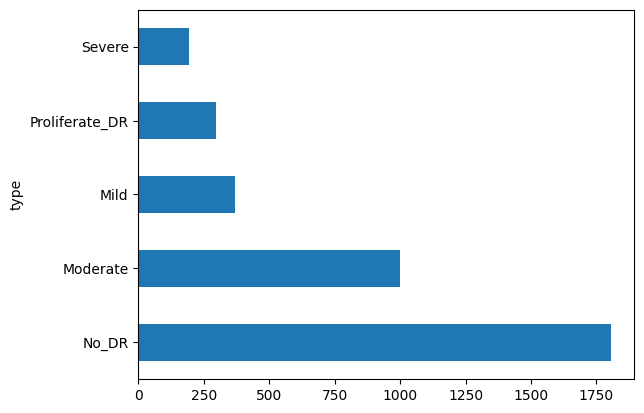

In [3]:
df['type'].value_counts().plot(kind='barh')

<Axes: ylabel='binary_type'>

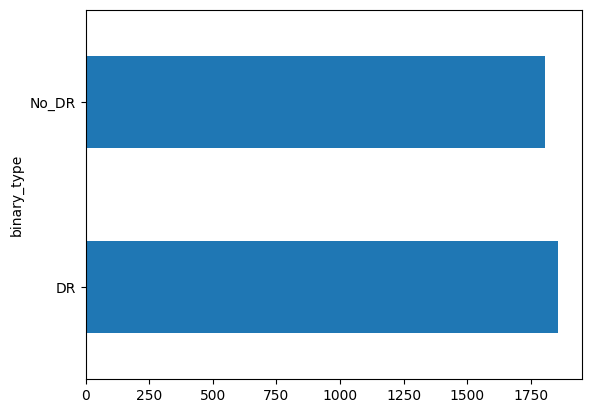

In [4]:
df['binary_type'].value_counts().plot(kind='barh')

In [5]:
# Setting up ImageDataGenerator for train/val/test

train_path = '/content/drive/MyDrive/Projeto IA/binary/train'
val_path = '/content/drive/MyDrive/Projeto IA/binary/val'
test_path = '/content/drive/MyDrive/Projeto IA/binary/test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)


Found 2572 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 318 images belonging to 2 classes.


In [6]:
# Building the model

model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history = model.fit(train_batches,
                    epochs=30,
                    validation_data=val_batches)

Epoch 1/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 754s 9s/step - acc: 0.7352 - loss: 0.5576 - val_acc: 0.5073 - val_loss: 0.7063
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 70s 226ms/step - acc: 0.8814 - loss: 0.3095 - val_acc: 0.5073 - val_loss: 0.7374
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 231ms/step - acc: 0.9004 - loss: 0.2523 - val_acc: 0.5418 - val_loss: 0.6491
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 18s 212ms/step - acc: 0.9160 - loss: 0.2336 - val_acc: 0.6855 - val_loss: 0.5236
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 17s 197ms/step - acc: 0.9261 - loss: 0.2243 - val_acc: 0.8691 - val_loss: 0.3723
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 19s 225ms/step - acc: 0.9244 - loss: 0.2096 - val_acc: 0.8982 - val_loss: 0.2775
Epoch 7/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 19s 226ms/step - acc: 0.9362 - loss: 0.1831 - val_acc: 0.9255 - val_loss: 0.2281
Epoch 8/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 17s 197ms/step - acc: 0.9252 - loss: 0.1870 - val_acc: 0.9291 - val_loss: 0.1919
Epoch 9/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 22s 223ms/st

In [7]:
model.save('64x3-CNN.h5')
model.save('64x3-CNN.keras')

In [8]:
loss, acc = model.evaluate(test_batches, verbose=1)
print("Accuracy: ", acc)
print("Loss: ", loss)

10/10 ━━━━━━━━━━━━━━━━━━━━ 105s 12s/step - acc: 0.9575 - loss: 0.1249
Accuracy:  0.9622641801834106
Loss:  0.1264893114566803


# ****Diabet Retinopathy Detection Section****

In [9]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


def predict_class(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    new_model = tf.keras.models.load_model("64x3-CNN.h5")
    predict=new_model.predict(np.array([image]))
    per=np.argmax(predict,axis=1)
    if per==1:
        print('No DR')
    else:
        print('DR')




1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
No DR


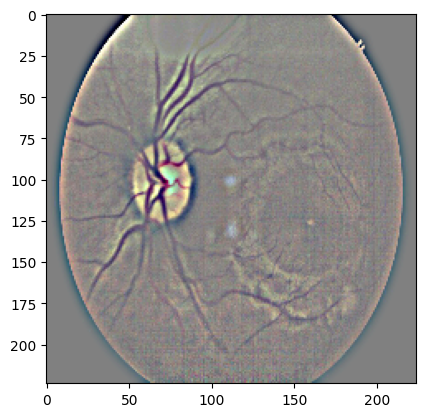

In [11]:
predict_class('/content/drive/MyDrive/Projeto IA/binary/test/No_DR/014508ccb9cb.png')

Saving 0318598cfd16.png to 0318598cfd16.png


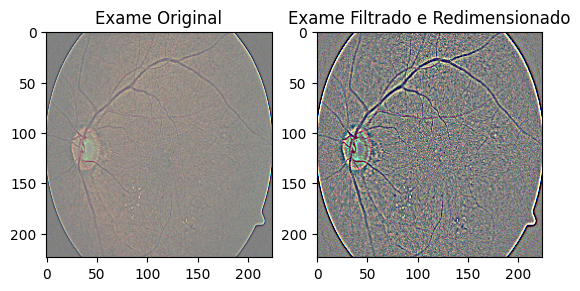

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
Pré Diagnóstico: Não há Retinopatia Diabética


In [13]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import files

# Função para aplicar o filtro gaussiano com a constante sigmaX e combinar com a imagem original
def apply_gaussian_filter(image, sigmaX):
    # Aplica o filtro gaussiano
    blurred = cv2.GaussianBlur(image, (0, 0), sigmaX)
    # Combina a imagem original com a imagem borrada
    result = cv2.addWeighted(image, 4, blurred, -4, 128)
    return result

# Função para prever a classe da imagem
def predict_class(path):
    # Verificar e criar o diretório /content/temp
    temp_dir = '/content/temp'
    if not os.path.exists(temp_dir):
        os.makedirs(temp_dir)

    # Limpar o diretório /content/temp
    for filename in os.listdir(temp_dir):
        file_path = os.path.join(temp_dir, filename)
        if os.path.isfile(file_path):
            os.remove(file_path)

    # Ler a imagem
    img = cv2.imread(path)

    # Mostrar a imagem original
    RGBImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 2, 1)
    plt.title("Exame Original")
    plt.imshow(RGBImg)

    # Aplicar o filtro gaussiano à imagem
    sigmaX = 3
    filtered_img = apply_gaussian_filter(img, sigmaX)

    # Redimensionar a imagem para 224x224
    resized_img = cv2.resize(filtered_img, (224, 224))

    # Exibir a imagem filtrada e redimensionada
    RGBImg_Filtered = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 2, 2)
    plt.title("Exame Filtrado e Redimensionado")
    plt.imshow(RGBImg_Filtered)
    plt.show()

    # Salvar a imagem resultante
    filtered_img_path = os.path.join(temp_dir, 'filtered_image.jpg')
    cv2.imwrite(filtered_img_path, resized_img)

    # Normalizar a imagem para o modelo
    image = np.array(resized_img) / 255.0

    # Carregar o modelo e fazer a predição
    new_model = tf.keras.models.load_model("64x3-CNN.h5")
    predict = new_model.predict(np.array([image]))
    per = np.argmax(predict, axis=1)

    # Exibir a predição
    if per == 1:
        print('Pré Diagnóstico: Não há Retinopatia Diabética')
    else:
        print('Pré Diagnóstico: Possível Retinopatia Diabética')

# Função para fazer o upload da imagem
def upload_and_predict():
    # Verificar e criar o diretório /content/temp
    temp_dir = '/content/temp'
    if not os.path.exists(temp_dir):
        os.makedirs(temp_dir)

    # Limpar o diretório /content/temp
    for filename in os.listdir(temp_dir):
        file_path = os.path.join(temp_dir, filename)
        if os.path.isfile(file_path):
            os.remove(file_path)

    uploaded = files.upload()  # Fazer o upload da imagem
    for filename in uploaded.keys():
        path = '/content/' + filename
        predict_class(path)

# Chamar a função de upload e predição
upload_and_predict()
